<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Machine%20Learning%20Project/Time%20series/%EB%AC%B8%EC%A0%9C12_%EC%9E%90%EC%A0%84%EA%B1%B0%ED%8C%90%EB%A7%A4%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 자전거판매 수요예측분석 (시계열문제유형)

### Step 0. 필요패키지 설치 및 데이터 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
from scipy import stats

##  Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# keras 시계열 딥러닝 관련
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)

In [ ]:
# Google colab: 데이터 경로 설정
path = '/content/drive/MyDrive/Colab Notebooks/practice/시계열문제/data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(path)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


### Step 1. 시계열데이터 전처리

In [ ]:
raw_all.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,17379,17379,2012-12-31 6:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,379.00",NaN,NaN,NaN,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,379.00",NaN,NaN,NaN,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,379.00",NaN,NaN,NaN,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,379.00",NaN,NaN,NaN,1.43,0.64,1.00,1.00,1.00,2.00,4.00
temp,"17,379.00",NaN,NaN,NaN,20.38,7.89,0.82,13.94,20.50,27.06,41.00
atemp,"17,379.00",NaN,NaN,NaN,23.79,8.59,0.00,16.66,24.24,31.06,50.00
humidity,"17,379.00",NaN,NaN,NaN,62.72,19.29,0.00,48.00,63.00,78.00,100.00
windspeed,"17,379.00",NaN,NaN,NaN,12.74,8.20,0.00,7.00,13.00,17.00,57.00
casual,"17,379.00",NaN,NaN,NaN,35.68,49.31,0.00,4.00,17.00,48.00,367.00


In [ ]:
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      17379 non-null  int64  
 10  registered  17379 non-null  int64  
 11  count       17379 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.6+ MB


#### 인덱스 datetime 변수 전환

In [ ]:
# string to datetime /문자타입을 시간정보로 바꿈.
if 'datetime' in raw_all.columns:
    raw_all['datetime'] = pd.to_datetime(raw_all['datetime'])
    raw_all['DateTime'] = pd.to_datetime(raw_all['datetime']) # 다른 활용을 위해서, 하나 더 만듬.
raw_all.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   holiday     17379 non-null  int64         
 3   workingday  17379 non-null  int64         
 4   weather     17379 non-null  int64         
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   humidity    17379 non-null  int64         
 8   windspeed   17379 non-null  float64       
 9   casual      17379 non-null  int64         
 10  registered  17379 non-null  int64         
 11  count       17379 non-null  int64         
 12  DateTime    17379 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(8)
memory usage: 1.7 MB


In [ ]:
# 인댁스 타입을 아까 하나 더 변환해준  DateTime로 변경.
# set index as datetime column
if raw_all.index.dtype == 'int64':
    raw_all.set_index('DateTime', inplace=True)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90


In [ ]:
raw_all.describe(include='all').T
raw_all.isnull()
raw_all.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

#### 빈도(frequence)추출

In [ ]:
# frequence 를 시간으로 세팅. asfreq('H') / nan 값도 확인해줌
raw_all.asfreq('H')[raw_all.asfreq('H').isnull().sum(axis=1) > 0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-02 05:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2011-01-03 02:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2011-01-03 03:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2011-01-04 03:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2011-01-05 03:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-30 12:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2012-11-08 03:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2012-11-29 03:00:00,NaT,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
raw_all.asfreq('H').head(100)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
DateTime,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1.00,0.00,0.00,1.00,9.84,14.39,81.00,0.00,3.00,13.00,16.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1.00,0.00,0.00,1.00,9.02,13.63,80.00,0.00,8.00,32.00,40.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1.00,0.00,0.00,1.00,9.02,13.63,80.00,0.00,5.00,27.00,32.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1.00,0.00,0.00,1.00,9.84,14.39,75.00,0.00,3.00,10.00,13.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1.00,0.00,0.00,1.00,9.84,14.39,75.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-04 23:00:00,2011-01-04 23:00:00,1.00,0.00,1.00,1.00,8.20,11.37,69.00,6.00,2.00,9.00,11.00
2011-01-05 00:00:00,2011-01-05 00:00:00,1.00,0.00,1.00,1.00,8.20,12.88,64.00,0.00,0.00,6.00,6.00
2011-01-05 01:00:00,2011-01-05 01:00:00,1.00,0.00,1.00,1.00,6.56,9.85,74.00,6.00,0.00,6.00,6.00


In [ ]:
# nan값 채워줌
raw_all = raw_all.asfreq('H', method='ffill')
raw_all.isnull().sum()


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

#### 계절성, 트렌드 추출

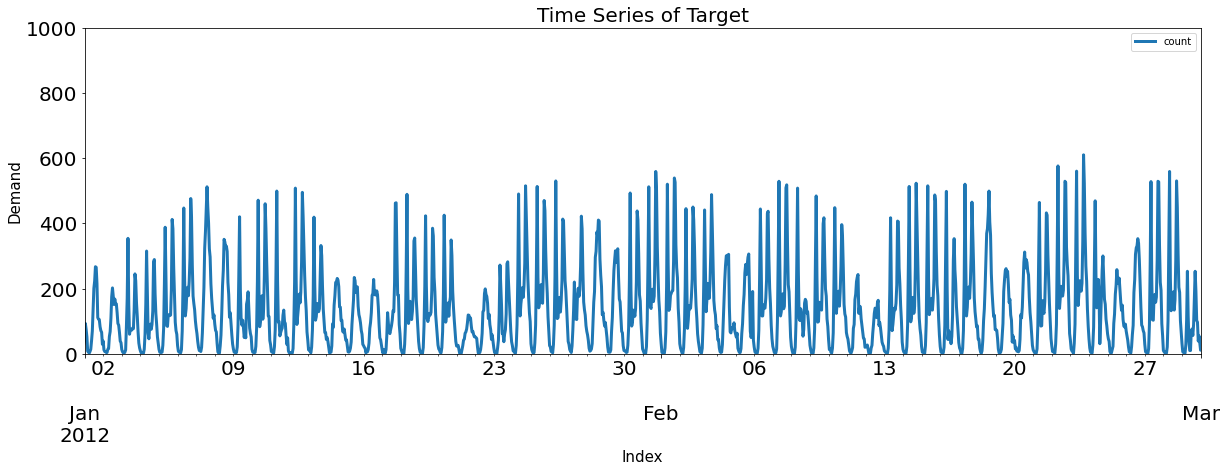

In [ ]:
# line plot of Y
raw_all[['count']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                              xlim=('2012-01-01', '2012-03-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

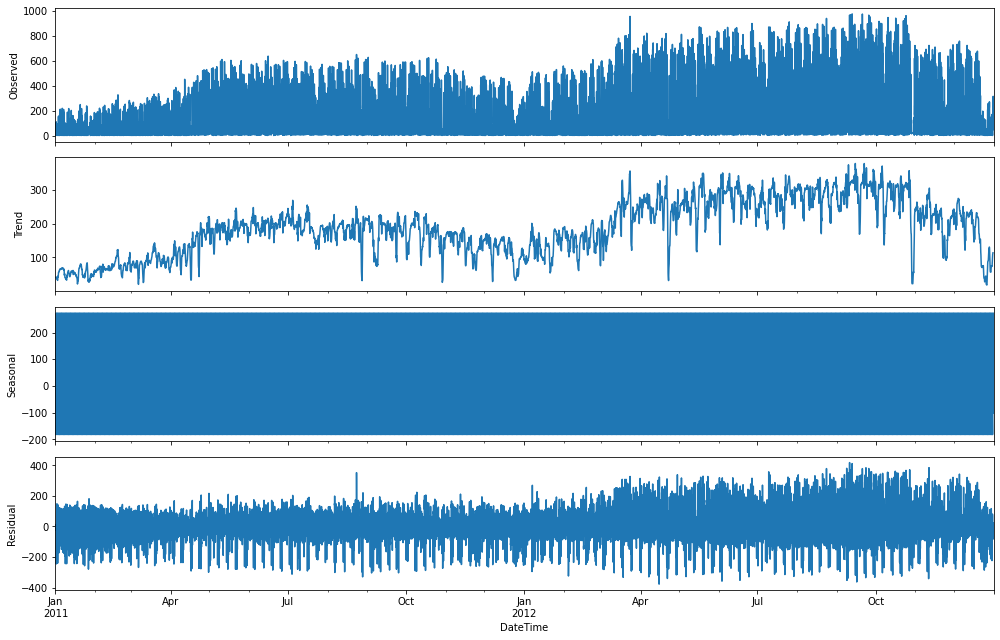

In [ ]:
# split data as trend + seasonal + residual 추세와 트렌드 잔차를 분리.
# sm.tsa.seasonal_decompose 모듈사용
import statsmodels.api as sm 
from scipy import stats
plt.rcParams['figure.figsize'] = (14, 9)
sm.tsa.seasonal_decompose(raw_all['count'], model='additive').plot()
plt.show()

In [ ]:
# fill nan as some values of data
# seasonal_decompose 잔차 추출
# trend와 seasonal을 변수로 담는다.
result = sm.tsa.seasonal_decompose(raw_all['count'], model='additive')
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True)
Y_trend.fillna(method='bfill', inplace=True)
Y_trend.columns = ['count_trend']
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']
Y_seasonal

,count_seasonal
DateTime,
2011-01-01 00:00:00,-134.25
2011-01-01 01:00:00,-154.75
2011-01-01 02:00:00,-165.27
2011-01-01 03:00:00,-176.48
2011-01-01 04:00:00,-181.67
...,...
2012-12-31 19:00:00,122.70
2012-12-31 20:00:00,37.48
2012-12-31 21:00:00,-16.10


In [ ]:
Y_trend

,count_trend
DateTime,
2011-01-01 00:00:00,41.06
2011-01-01 01:00:00,41.06
2011-01-01 02:00:00,41.06
2011-01-01 03:00:00,41.06
2011-01-01 04:00:00,41.06
...,...
2012-12-31 19:00:00,113.71
2012-12-31 20:00:00,113.71
2012-12-31 21:00:00,113.71


In [ ]:
raw_all.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [ ]:
# merging several columns
raw_all = pd.concat([raw_all, Y_trend, Y_seasonal], axis=1)


In [ ]:
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal
DateTime,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10


#### 일일패턴 및 주별패턴 변수 전환

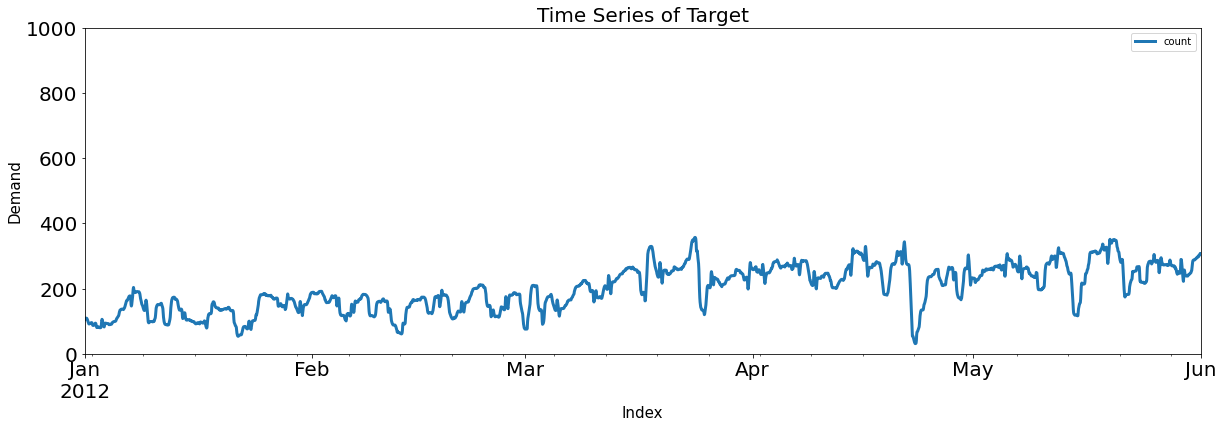

In [ ]:
# rolling(24).mean().plot 앞뒤로 12개 12개 씩 24개의 데이터로 묶어서 평균값을 내서 시각화
raw_all[['count']].rolling(24).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

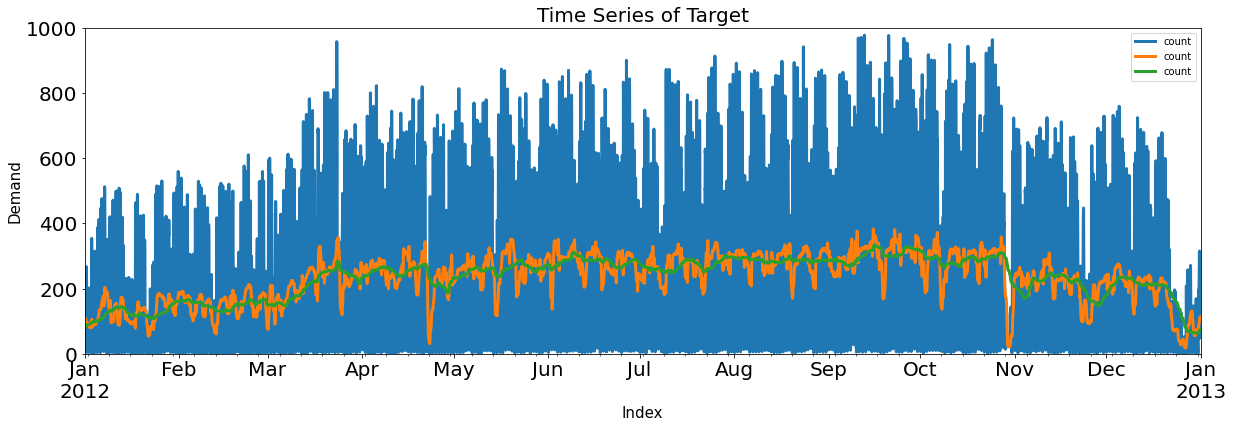

In [ ]:
# comparison of several moving average values
pd.concat([raw_all[['count']],
           raw_all[['count']].rolling(24).mean(), # 일일패턴
           # 주별패턴
           raw_all[['count']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2012-01-01', '2013-01-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()


In [ ]:
Y_count_Day = raw_all[['count']].rolling(24).mean()
Y_count_Day.fillna(method='ffill', inplace=True)
Y_count_Day.fillna(method='bfill', inplace=True)
Y_count_Day.columns = ['count_Day']
Y_count_Week = raw_all[['count']].rolling(24*7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']

raw_all = pd.concat([raw_all, Y_count_Day, Y_count_Week], axis=1)
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week
DateTime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11


In [ ]:
raw_all[['count']]

,count
DateTime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1
...,...
2012-12-31 19:00:00,119
2012-12-31 20:00:00,89
2012-12-31 21:00:00,90


#### 이전값 y변수 반영

In [ ]:
raw_all[['count']].diff(1)

,count
DateTime,
2011-01-01 00:00:00,nan
2011-01-01 01:00:00,24.00
2011-01-01 02:00:00,-8.00
2011-01-01 03:00:00,-19.00
2011-01-01 04:00:00,-12.00
...,...
2012-12-31 19:00:00,-3.00
2012-12-31 20:00:00,-30.00
2012-12-31 21:00:00,1.00


In [ ]:
# diff of Y and merging
Y_diff = raw_all[['count']].diff()
Y_diff.fillna(method='bfill', inplace=True)
Y_diff.columns = ['count_diff']

In [ ]:
raw_all = pd.concat([raw_all, Y_diff], axis=1)

In [ ]:
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff
DateTime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00


In [ ]:
raw_all.isnull().sum().sum()

0

#### 시간정보추출(연도 및 분기)

In [ ]:
# feature extraction of time information
raw_all['Year'] = raw_all.datetime.dt.year
# 'Quater 연도구분 없음
raw_all['Quater'] = raw_all.datetime.dt.quarter
raw_all.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater
count,"17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00"
mean,2.50,0.03,0.68,1.43,20.30,23.71,62.87,12.81,35.35,152.44,187.80,187.79,0.00,187.74,187.67,0.00,"2,011.50",2.51
std,1.11,0.17,0.47,0.65,7.92,8.62,19.34,8.29,49.19,151.28,181.35,80.16,128.50,80.25,73.12,100.90,0.50,1.12
min,1.00,0.00,0.00,1.00,0.82,0.00,0.00,0.00,0.00,0.00,1.00,18.06,-181.67,18.04,45.95,-523.00,"2,011.00",1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,48.00,7.00,4.00,32.00,38.00,130.56,-117.81,130.29,137.19,-39.00,"2,011.00",2.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,63.00,13.00,16.00,114.00,140.00,188.47,21.32,188.48,185.83,-4.00,"2,012.00",3.00
75%,3.00,0.00,1.00,2.00,27.06,31.06,79.00,17.00,48.00,219.00,279.00,247.46,64.69,247.42,254.88,30.00,"2,012.00",4.00
max,4.00,1.00,1.00,4.00,41.00,50.00,100.00,57.00,367.00,886.00,977.00,379.06,273.37,382.50,332.99,519.00,"2,012.00",4.00


In [ ]:
# Quater_ver2 연도구분ver1. 해석유의함
raw_all['Quater_ver2'] = raw_all['Quater'] + (raw_all.Year - raw_all.Year.min()) * 4
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater,Quater_ver2
DateTime,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,2011,1,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,2011,1,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,2011,1,1
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,2011,1,1
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,2011,1,1


In [ ]:
# feature extraction of time information
raw_all['Month'] = raw_all.datetime.dt.month
raw_all['Day'] = raw_all.datetime.dt.day
raw_all['Hour'] = raw_all.datetime.dt.hour
raw_all['DayofWeek'] = raw_all.datetime.dt.dayofweek
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek
DateTime,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,2011,1,1,1,1,0,5
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,2011,1,1,1,1,1,5
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,2011,1,1,1,1,2,5
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,2011,1,1,1,1,3,5
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,2011,1,1,1,1,4,5


In [ ]:
raw_all.info()
raw_all.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        17544 non-null  datetime64[ns]
 1   season          17544 non-null  int64         
 2   holiday         17544 non-null  int64         
 3   workingday      17544 non-null  int64         
 4   weather         17544 non-null  int64         
 5   temp            17544 non-null  float64       
 6   atemp           17544 non-null  float64       
 7   humidity        17544 non-null  int64         
 8   windspeed       17544 non-null  float64       
 9   casual          17544 non-null  int64         
 10  registered      17544 non-null  int64         
 11  count           17544 non-null  int64         
 12  count_trend     17544 non-null  float64       
 13  count_seasonal  17544 non-null  float64       
 14  count_Day  

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaT,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaT,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaT,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaT,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
temp,"17,544.00",NaN,NaT,NaN,NaT,NaT,20.30,7.92,0.82,13.94,20.50,27.06,41.00
atemp,"17,544.00",NaN,NaT,NaN,NaT,NaT,23.71,8.62,0.00,16.66,24.24,31.06,50.00
humidity,"17,544.00",NaN,NaT,NaN,NaT,NaT,62.87,19.34,0.00,48.00,63.00,79.00,100.00
windspeed,"17,544.00",NaN,NaT,NaN,NaT,NaT,12.81,8.29,0.00,7.00,13.00,17.00,57.00
casual,"17,544.00",NaN,NaT,NaN,NaT,NaT,35.35,49.19,0.00,4.00,16.00,48.00,367.00


#### 지연값 세팅

In [ ]:
raw_all['count_lag1'] = raw_all['count'].shift(1)
raw_all['count_lag2'] = raw_all['count'].shift(2)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,2011,1,1,1,1,0,5,nan,nan
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,2011,1,1,1,1,1,5,16.00,nan
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,2011,1,1,1,1,2,5,40.00,16.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,2011,1,1,1,1,3,5,32.00,40.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,2011,1,1,1,1,4,5,13.00,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70,110.17,73.30,-3.00,2012,4,8,12,31,19,0,122.00,164.00
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48,110.88,73.70,-30.00,2012,4,8,12,31,20,0,119.00,122.00
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10,112.67,74.10,1.00,2012,4,8,12,31,21,0,89.00,119.00


In [ ]:
raw_all['count_lag1'].fillna(method='bfill', inplace=True)
raw_all['count_lag2'].fillna(method='bfill', inplace=True)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,2011,1,1,1,1,0,5,16.00,16.00
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,2011,1,1,1,1,1,5,16.00,16.00
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,2011,1,1,1,1,2,5,40.00,16.00
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,2011,1,1,1,1,3,5,32.00,40.00
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,2011,1,1,1,1,4,5,13.00,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,113.71,122.70,110.17,73.30,-3.00,2012,4,8,12,31,19,0,122.00,164.00
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,113.71,37.48,110.88,73.70,-30.00,2012,4,8,12,31,20,0,119.00,122.00
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,113.71,-16.10,112.67,74.10,1.00,2012,4,8,12,31,21,0,89.00,119.00


####  더미변수 세팅 _Quater

In [ ]:
if 'Quater' in raw_all.columns:
    raw_all = pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
], axis=1)
    del raw_all['Quater']
raw_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,2011,1,1,1,4,5,13.00,32.00,0,0,0


### Step 2. 시각화 분석

In [ ]:
raw_all.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaT,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaT,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaT,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaT,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
temp,"17,544.00",NaN,NaT,NaN,NaT,NaT,20.30,7.92,0.82,13.94,20.50,27.06,41.00
atemp,"17,544.00",NaN,NaT,NaN,NaT,NaT,23.71,8.62,0.00,16.66,24.24,31.06,50.00
humidity,"17,544.00",NaN,NaT,NaN,NaT,NaT,62.87,19.34,0.00,48.00,63.00,79.00,100.00
windspeed,"17,544.00",NaN,NaT,NaN,NaT,NaT,12.81,8.29,0.00,7.00,13.00,17.00,57.00
casual,"17,544.00",NaN,NaT,NaN,NaT,NaT,35.35,49.19,0.00,4.00,16.00,48.00,367.00


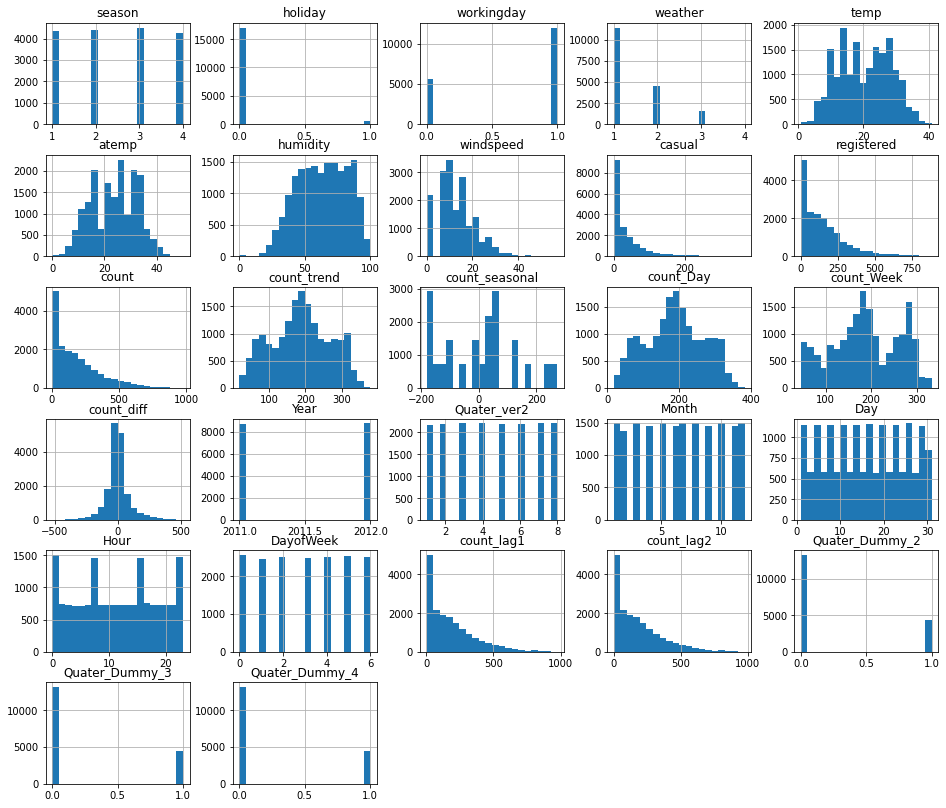

In [ ]:
# histogram plot
raw_all.hist(bins=20, grid=True, figsize=(16,14))
plt.show()
# Y는 COUNT 이다. 따라서, COUNT와 유사한 그래프 형태의 변수가 Y에 많은 영향을 주는 변수라는 것을 유추

(0.0, 1000.0)

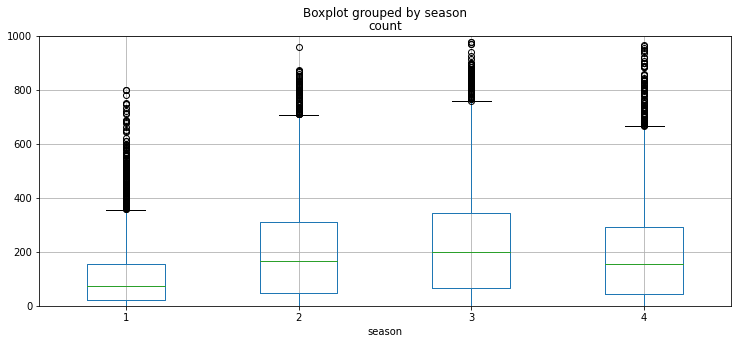

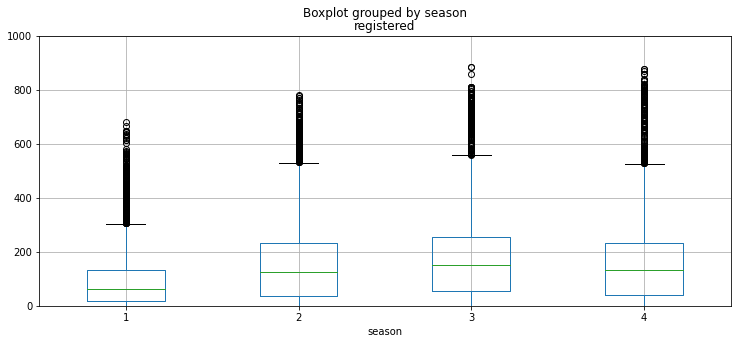

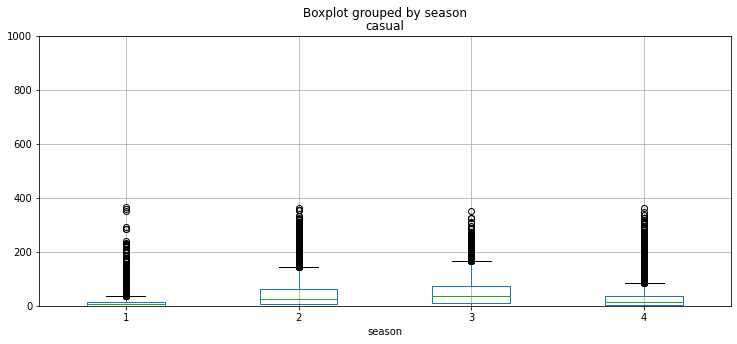

In [ ]:
# box plot
raw_all.boxplot(column='count', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='registered', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='casual', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)

(0.0, 1000.0)

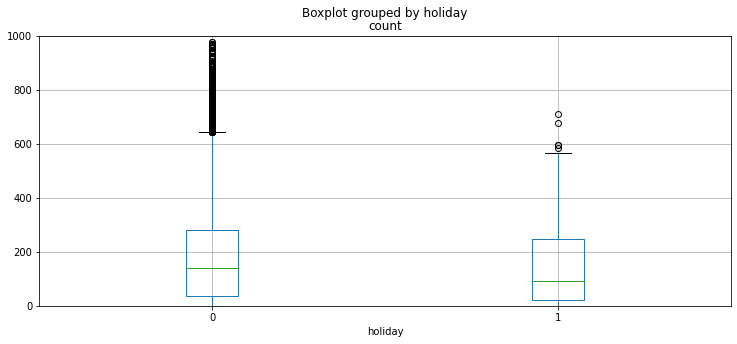

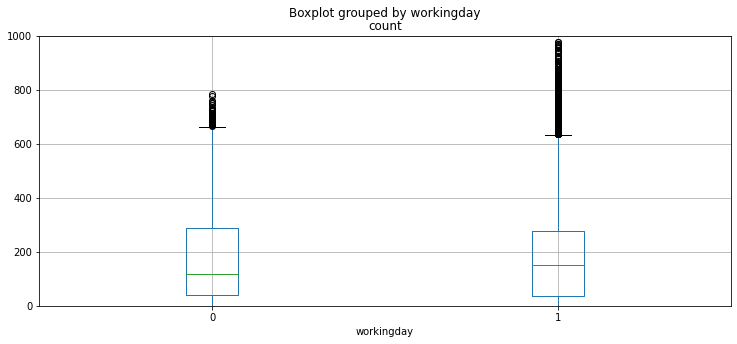

In [ ]:
# box plot
raw_all.boxplot(column='count', by='holiday', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='count', by='workingday', grid=True, figsize=(12,5))
plt.ylim(0,1000)

In [ ]:
raw_all['weather'].value_counts()

1    11455
2     4563
3     1523
4        3
Name: weather, dtype: int64

In [ ]:
raw_all['weather'].value_counts().sum()

17544

In [ ]:
pd.DataFrame(raw_all['weather'].value_counts()/raw_all['weather'].value_counts().sum()*100).T

,1,2,3,4
weather,65.29,26.01,8.68,0.02


In [ ]:
pd.crosstab(index=raw_all['count'], columns=raw_all['weather'], margins=True)

weather,1,2,3,4,All
count,,,,,
1,100,45,27,0,172
2,136,59,37,0,232
3,136,66,41,0,243
4,149,62,36,0,247
5,164,63,36,0,263
...,...,...,...,...,...
968,1,0,0,0,1
970,1,0,0,0,1
976,1,0,0,0,1


In [ ]:
sub_table = pd.crosstab(index=raw_all['count'], columns=raw_all['weather'], margins=True)
sub_table/sub_table.loc['All']*100

weather,1,2,3,4,All
count,,,,,
1,0.87,0.99,1.77,0.00,0.98
2,1.19,1.29,2.43,0.00,1.32
3,1.19,1.45,2.69,0.00,1.39
4,1.30,1.36,2.36,0.00,1.41
5,1.43,1.38,2.36,0.00,1.50
...,...,...,...,...,...
968,0.01,0.00,0.00,0.00,0.01
970,0.01,0.00,0.00,0.00,0.01
976,0.01,0.00,0.00,0.00,0.01


In [ ]:
raw_all.groupby(['weather', 'DayofWeek']).count()
raw_all.groupby(['weather', 'DayofWeek']).mean()

season  holiday  workingday  temp  atemp  humidity  \
weather DayofWeek                                                       
1       0            2.45     0.14        0.86 20.70  24.23     59.05   
        1            2.48     0.00        1.00 21.36  24.89     57.11   
        2            2.50     0.01        0.99 21.61  25.08     58.23   
        3            2.53     0.03        0.97 21.35  24.88     55.85   
        4            2.56     0.03        0.97 20.71  24.00     57.06   
        5            2.52     0.00        0.00 20.43  23.84     56.15   
        6            2.50     0.00        0.00 20.32  23.80     58.33   
2       0            2.59     0.16        0.84 19.72  23.20     68.87   
        1            2.51     0.02        0.98 19.85  23.37     71.91   
        2            2.56     0.00        1.00 19.61  23.00     70.45   
        3            2.54     0.00        1.00 19.95  23.39     70.67   
        4            2.38     0.01        0.99 19.44  22.61     66.64   
        5            2.41     0.00        0.00 18.81  22.06     69.69   
        6            2.41     0.00        0.00 18.36  21.70     71.30   
3       0            2.48     0.17        0.83 17.36  20.43     83.95   
        1            2.82     0.00        1.00 19.97  23.27     84.92   
        2            2.34     0.00        1.00 17.53  20.39     86.04   
        3            2.33     0.00        1.00 18.14  21.05     73.08   
        4            2.26     0.00        1.00 19.90  22.87     81.68   
        5            2.31     0.00        0.00 17.50  20.48     86.43   
        6            2.62     0.00        0.00 19.17  22.40     81.39   
4       0            1.00     0.00        1.00  8.20  11.37     86.00   
        2            1.00     0.00        1.00  9.02   9.85     93.00   
        5            1.00     0.00        0.00  5.74   6.82     86.00   

                   windspeed  casual  registered  count  count_trend  \
weather DayofWeek                                                      
1       0              12.86   30.40      160.04 190.43       184.94   
        1              12.95   27.57      186.58 214.14       201.26   
        2              12.22   26.65      181.52 208.17       208.47   
        3              13.01   28.95      184.81 213.77       207.36   
        4              12.73   33.50      168.64 202.14       203.09   
        5              12.98   68.51      138.94 207.45       206.99   
        6              12.58   63.25      130.72 193.96       187.89   
2       0              11.75   27.82      153.35 181.17       170.81   
        1              11.80   18.46      145.10 163.56       174.32   
        2              12.42   20.09      163.88 183.97       180.77   
        3              12.47   18.66      157.31 175.97       180.05   
        4              11.52   30.55      169.72 200.27       188.72   
        5              12.91   51.98      118.76 170.75       174.72   
        6              11.60   40.40      101.05 141.44       168.54   
3       0              16.87    9.54       81.81  91.35       118.59   
        1              15.42   11.94      104.54 116.47       152.54   
        2              15.06    9.23       91.77 101.00       108.97   
        3              12.77    8.24       92.73 100.97       127.52   
        4              13.63   14.83      102.66 117.49       149.19   
        5              18.08   26.43       70.57  97.00       118.47   
        6              16.12   31.76       84.02 115.78       145.71   
4       0               6.00    6.00      158.00 164.00        98.85   
        2              22.00    1.00       35.00  36.00        31.33   
        5              13.00    1.00       22.00  23.00        87.67   

                   count_seasonal  count_Day  count_Week  count_diff     Year  \
weather DayofWeek                                                               
1       0                   -3.81     179.74      186.79        1.66 2,011.49   
    

In [ ]:
# pivot table using groupby
raw_all.groupby(['weather', 'DayofWeek']).describe()

season                                     holiday       \
                     count mean  std  min  25%  50%  75%  max    count mean   
weather DayofWeek                                                             
1       0         1,594.00 2.45 1.09 1.00 1.00 2.00 3.00 4.00 1,594.00 0.14   
        1         1,527.00 2.48 1.07 1.00 2.00 3.00 3.00 4.00 1,527.00 0.00   
        2         1,577.00 2.50 1.06 1.00 2.00 3.00 3.00 4.00 1,577.00 0.01   
        3         1,660.00 2.53 1.06 1.00 2.00 3.00 3.00 4.00 1,660.00 0.03   
        4         1,649.00 2.56 1.08 1.00 2.00 3.00 4.00 4.00 1,649.00 0.03   
        5         1,676.00 2.52 1.12 1.00 2.00 3.00 4.00 4.00 1,676.00 0.00   
        6         1,772.00 2.50 1.12 1.00 1.00 3.00 3.00 4.00 1,772.00 0.00   
2       0           728.00 2.59 1.14 1.00 2.00 3.00 4.00 4.00   728.00 0.16   
        1           699.00 2.51 1.17 1.00 1.00 2.00 4.00 4.00   699.00 0.02   
        2           615.00 2.56 1.15 1.00 2.00 2.00 4.00 4.00   615.00 0.00   
        3           637.00 2.54 1.17 1.00 1.00 3.00 4.00 4.00   637.00 0.00   
        4           664.00 2.38 1.17 1.00 1.00 2.00 3.00 4.00   664.00 0.01   
        5           649.00 2.41 1.12 1.00 1.00 2.00 3.00 4.00   649.00 0.00   
        6           571.00 2.41 1.15 1.00 1.00 2.00 4.00 4.00   571.00 0.00   
3       0           228.00 2.48 1.23 1.00 1.00 2.00 4.00 4.00   228.00 0.17   
        1           239.00 2.82 1.10 1.00 2.00 3.00 4.00 4.00   239.00 0.00   
        2           319.00 2.34 1.21 1.00 1.00 2.00 4.00 4.00   319.00 0.00   
        3           183.00 2.33 1.20 1.00 1.00 2.00 3.50 4.00   183.00 0.00   
        4           183.00 2.26 1.08 1.00 1.00 2.00 3.00 4.00   183.00 0.00   
        5           201.00 2.31 1.04 1.00 1.00 2.00 3.00 4.00   201.00 0.00   
        6           170.00 2.62 1.08 1.00 2.00 3.00 4.00 4.00   170.00 0.00   
4       0             1.00 1.00  nan 1.00 1.00 1.00 1.00 1.00     1.00 0.00   
        2             1.00 1.00  nan 1.00 1.00 1.00 1.00 1.00     1.00 0.00   
        5             1.00 1.00  nan 1.00 1.00 1.00 1.00 1.00     1.00 0.00   

                                                workingday                 \
                   std  min  25%  50%  75%  max      count mean  std  min   
weather DayofWeek                                                           
1       0         0.35 0.00 0.00 0.00 0.00 1.00   1,594.00 0.86 0.35 0.00   
        1         0.06 0.00 0.00 0.00 0.00 1.00   1,527.00 1.00 0.06 0.00   
        2         0.12 0.00 0.00 0.00 0.00 1.00   1,577.00 0.99 0.12 0.00   
        3         0.17 0.00 0.00 0.00 0.00 1.00   1,660.00 0.97 0.17 0.00   
        4         0.16 0.00 0.00 0.00 0.00 1.00   1,649.00 0.97 0.16 0.00   
        5         0.00 0.00 0.00 0.00 0.00 0.00   1,676.00 0.00 0.00 0.00   
        6         0.00 0.00 0.00 0.00 0.00 0.00   1,772.00 0.00 0.00 0.00   
2       0         0.36 0.00 0.00 0.00 0.00 1.00     728.00 0.84 0.36 0.00   
        1         0.15 0.00 0.00 0.00 0.00 1.00     699.00 0.98 0.15 0.00   
        2         0.04 0.00 0.00 0.00 0.00 1.00     615.00 1.00 0.04 0.00   
        3         0.00 0.00 0.00 0.00 0.00 0.00     637.00 1.00 0.00 1.00   
        4         0.09 0.00 0.00 0.00 0.00 1.00     664.00 0.99 0.09 0.00   
        5         0.00 0.00 0.00 0.00 0.00 0.00     649.00 0.00 0.00 0.00   
        6         0.00 0.00 0.00 0.00 0.00 0.00     571.00 0.00 0.00 0.00   
3       0         0.38 0.00 0.00 0.00 0.00 1.00     228.00 0.83 0.38 0.00   
        1         0.06 0.00 0.00 0.00 0.00 1.00     239.00 1.00 0.06 0.00   
        2         0.00 0.00 0.00 0.00 0.00 0.00     319.00 1.00 0.00 1.00   
        3         0.00 0.00 0.00 0.00 0.00 0.00     183.00 1.00 0.00 1.00   
        4         0.00 0.00 0.00 0.00 0.00 0.00     183.00 1.00 0.00 1.00   
        5         0.00 0.00 0.00 0.00 0.00 0.00     201.00 0.00 0.00 0.00   
        6         0.00 0.00 0.00 0.00 0.00 0.00     170.00 0.00 0.00 0.00   
4       0          nan 0.00 0.00 0.00 

In [ ]:
raw_all.groupby(['weather', 'DayofWeek']).agg({'count':[sum, min, max]})

count          
                      sum  min  max
weather DayofWeek                  
1       0          303551    1  968
        1          326993    1  970
        2          328285    1  977
        3          354852    1  976
        4          333333    1  900
        5          347684    1  760
        6          343702    1  776
2       0          131892    1  842
        1          114330    1  868
        2          113142    1  862
        3          112093    1  905
        4          132976    1  957
        5          110816    1  783
        6           80765    1  626
3       0           20827    1  856
        1           27837    1  819
        2           32218    1  891
        3           18477    1  689
        4           21500    1  565
        5           19498    1  584
        6           19683    1  626
4       0             164  164  164
        2              36   36   36
        5              23   23   23

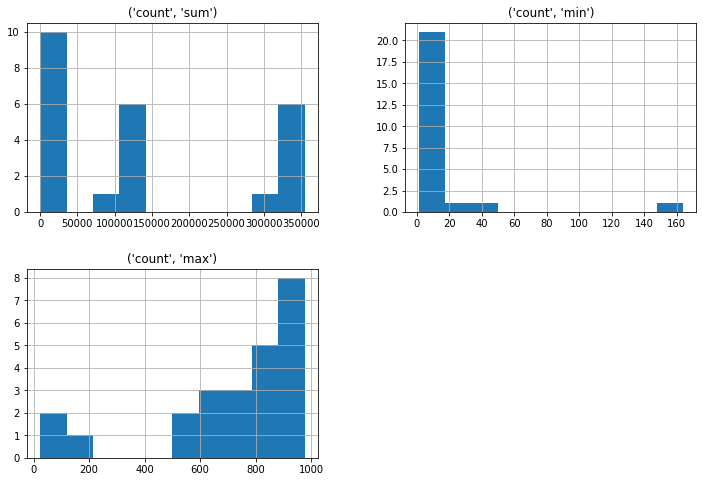

In [ ]:
raw_all.groupby(['weather', 'DayofWeek']).agg({'count':[sum, min, max]}).hist(grid=True, figsize=(12,8))
plt.show()

In [ ]:
pd.cut(raw_all['temp'], 10).value_counts()

(24.928, 28.946]    3164
(12.874, 16.892]    2926
(20.91, 24.928]     2687
(16.892, 20.91]     2474
(8.856, 12.874]     2466
(28.946, 32.964]    1976
(4.838, 8.856]      1018
(32.964, 36.982]     625
(0.78, 4.838]        124
(36.982, 41.0]        84
Name: temp, dtype: int64

In [ ]:
# desctiprion of groupby results
raw_all.groupby(pd.cut(raw_all['temp'], 10)).describe().T

temp                  (0.78, 4.838]  (4.838, 8.856]  (8.856, 12.874]  \
season         count         124.00        1,018.00         2,466.00   
               mean            1.00            1.22             2.02   
               std             0.00            0.75             1.36   
               min             1.00            1.00             1.00   
               25%             1.00            1.00             1.00   
...                             ...             ...              ...   
Quater_Dummy_4 min             0.00            0.00             0.00   
               25%             0.00            0.00             0.00   
               50%             0.00            0.00             0.00   
               75%             0.00            0.00             1.00   
               max             0.00            1.00             1.00   

temp                  (12.874, 16.892]  (16.892, 20.91]  (20.91, 24.928]  \
season         count          2,926.00         2,474.00         2,687.00   
               mean               2.51             2.66             2.71   
               std                1.36             1.21             0.96   
               min                1.00             1.00             1.00   
               25%                1.00             2.00             2.00   
...                                ...              ...              ...   
Quater_Dummy_4 min                0.00             0.00             0.00   
               25%                0.00             0.00             0.00   
               50%                0.00             0.00             0.00   
               75%                1.00             1.00             0.00   
               max                1.00             1.00             1.00   

temp                  (24.928, 28.946]  (28.946, 32.964]  (32.964, 36.982]  \
season         count          3,164.00          1,976.00            625.00   
               mean               2.73              2.80              2.86   
               std                0.65              0.44              0.35   
               min                1.00              1.00              2.00   
               25%                2.00              3.00              3.00   
...                                ...               ...               ...   
Quater_Dummy_4 min                0.00              0.00              0.00   
               25%                0.00              0.00              0.00   
               50%                0.00              0.00              0.00   
               75%                0.00              0.00              0.00   
               max                1.00              1.00              0.00   

temp                  (36.982, 41.0]  
season         count           84.00  
               mean             2.90  
               std              0.30  
               min              2.00  
               25%              3.00  
...                              ...  
Quater_Dummy_4 min              0.00  
               25%              0.00  
               50%              0.00  
               75%              0.00  
               max              0.00  

[216 rows x 10 columns]

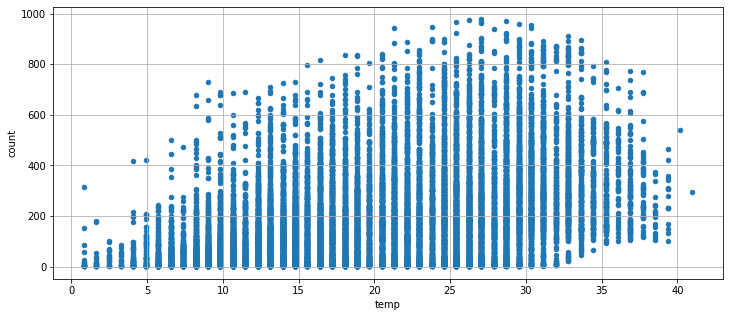

In [ ]:
# scatter plot sxample
raw_all.plot.scatter(y='count', x='temp', grid=True, figsize=(12,5))
plt.show()

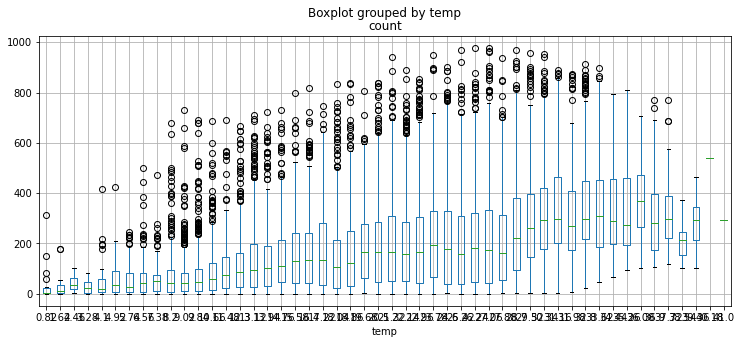

In [ ]:
# box plot example
raw_all.boxplot(column='count', by='temp', grid=True, figsize=(12,5))
plt.show()

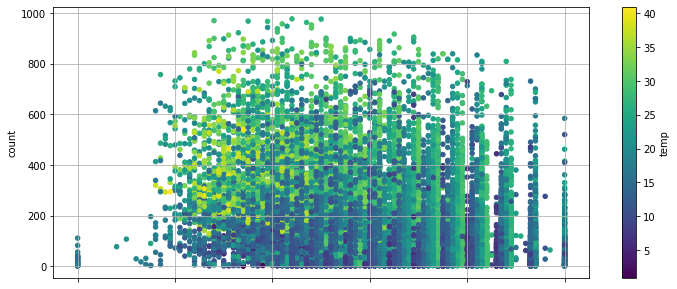

In [ ]:
# scatter plot example
raw_all.plot.scatter(y='count', x='humidity', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

In [ ]:
raw_all.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1.00,-0.02,0.02,-0.02,0.32,0.33,0.15,-0.14,0.12,0.18,0.18,0.41,0.00,0.41,0.47,-0.00,-0.00,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
holiday,-0.02,1.00,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,0.03,-0.05,-0.04,-0.08,-0.00,-0.07,-0.04,-0.00,0.00,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
workingday,0.02,-0.26,1.00,0.04,0.05,0.05,0.02,-0.02,-0.30,0.13,0.03,0.04,0.00,0.02,0.02,0.01,0.00,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weather,-0.02,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.16,-0.13,-0.15,-0.25,-0.00,-0.17,-0.07,-0.02,-0.02,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.32,-0.04,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.46,0.34,0.41,0.60,0.17,0.61,0.62,-0.00,0.05,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31
atemp,0.33,-0.04,0.05,-0.11,0.99,1.00,-0.06,-0.06,0.46,0.34,0.41,0.61,0.16,0.61,0.62,-0.01,0.05,0.15,0.22,0.02,0.13,-0.03,0.41,0.40,0.27,0.58,-0.29
humidity,0.15,-0.01,0.02,0.43,-0.07,-0.06,1.00,-0.27,-0.35,-0.28,-0.33,-0.09,-0.34,-0.06,0.04,0.00,-0.08,0.00,0.16,0.03,-0.27,-0.04,-0.33,-0.31,-0.03,0.06,0.10
windspeed,-0.14,0.01,-0.02,0.05,-0.02,-0.06,-0.27,1.00,0.08,0.07,0.08,-0.16,0.19,-0.14,-0.10,0.01,-0.01,-0.07,-0.13,0.02,0.14,-0.00,0.08,0.06,0.04,-0.10,-0.06
casual,0.12,0.03,-0.30,-0.16,0.46,0.46,-0.35,0.08,1.00,0.51,0.70,0.39,0.44,0.39,0.34,0.08,0.14,0.16,0.07,-0.01,0.30,0.24,0.65,0.58,0.15,0.17,-0.10
registered,0.18,-0.05,0.13,-0.13,0.34,0.34,-0.28,0.07,0.51,1.00,0.97,0.40,0.71,0.38,0.36,0.31,0.26,0.28,0.13,-0.01,0.37,-0.08,0.80,0.53,0.06,0.13,-0.00


In [ ]:
# y와의 상관관계# y와의 상관관계
raw_all.corr().loc[:, ['count']]

,count
season,0.18
holiday,-0.04
workingday,0.03
weather,-0.15
temp,0.41
atemp,0.41
humidity,-0.33
windspeed,0.08
casual,0.70
registered,0.97


###  Step 3. 시계열 데이터 분리

In [ ]:
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']


In [ ]:
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
len(X_colname)

24

In [ ]:
raw_train = raw_all.loc[raw_all.index < '2012-07-01',:]
raw_test = raw_all.loc[raw_all.index >= '2012-07-01',:]
print(raw_train.shape, raw_test.shape)

(13128, 28) (4416, 28)


In [ ]:
# data split of X and Y from train/test sets
Y_train = raw_train[Y_colname]
X_train = raw_train[X_colname]
Y_test = raw_test[Y_colname]
X_test = raw_test[X_colname]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(13128, 24) (13128, 1)
(4416, 24) (4416, 1)


In [ ]:
# calculation of lag data from Y
X_test['count_lag1'] = Y_test.shift(1).values
X_test['count_lag1'].fillna(method='bfill', inplace=True)
X_test['count_lag2'] = Y_test.shift(2).values
X_test['count_lag2'].fillna(method='bfill', inplace=True)
X_test['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 4416, dtype: float64

#### Step 4. 시계열 딥러닝 분석

#### GRU 모델링

In [ ]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0.05

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (13104, 24, 24) Y_train: (13104, 1)
X_test: (4392, 24, 24) Y_test: (4392, 1)


In [ ]:
# GRU 모델링
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 128)           59136     
_________________________________________________________________
dropout (Dropout)            (None, 24, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 256)           296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 128)           148224    
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                3

#### 학습

In [ ]:
# 학습
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)


Epoch 1/10
410/410 [==============================] - 74s 164ms/step - loss: 0.0201
Epoch 2/10
410/410 [==============================] - 67s 163ms/step - loss: 0.0047
Epoch 3/10
410/410 [==============================] - 66s 161ms/step - loss: 0.0034
Epoch 4/10
410/410 [==============================] - 66s 162ms/step - loss: 0.0026
Epoch 5/10
410/410 [==============================] - 65s 160ms/step - loss: 0.0022
Epoch 6/10
410/410 [==============================] - 66s 160ms/step - loss: 0.0019
Epoch 7/10
410/410 [==============================] - 66s 160ms/step - loss: 0.0016
Epoch 8/10
410/410 [==============================] - 65s 158ms/step - loss: 0.0016
Epoch 9/10
410/410 [==============================] - 66s 160ms/step - loss: 0.0014
Epoch 10/10
410/410 [==============================] - 66s 161ms/step - loss: 0.0013


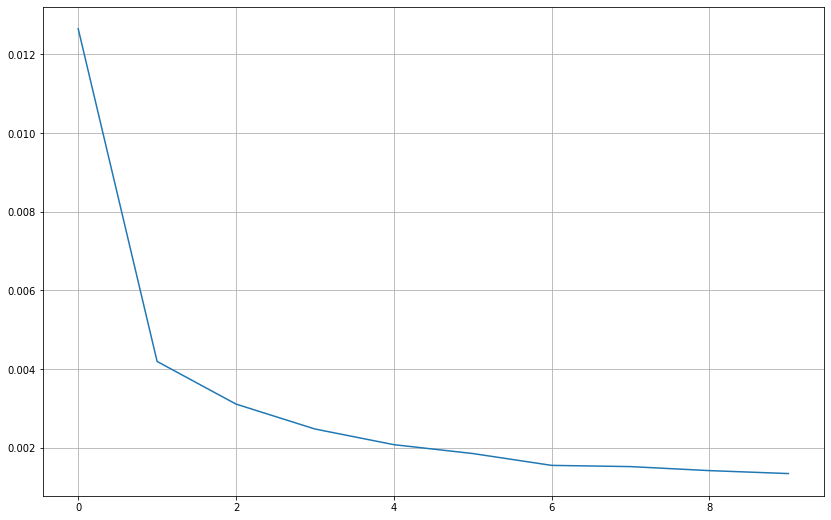

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

#### 예측

138/138 [==============================] - 2s 14ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,22.72,"1,014.75",68.31
Test,32.18,"2,069.78",47.04


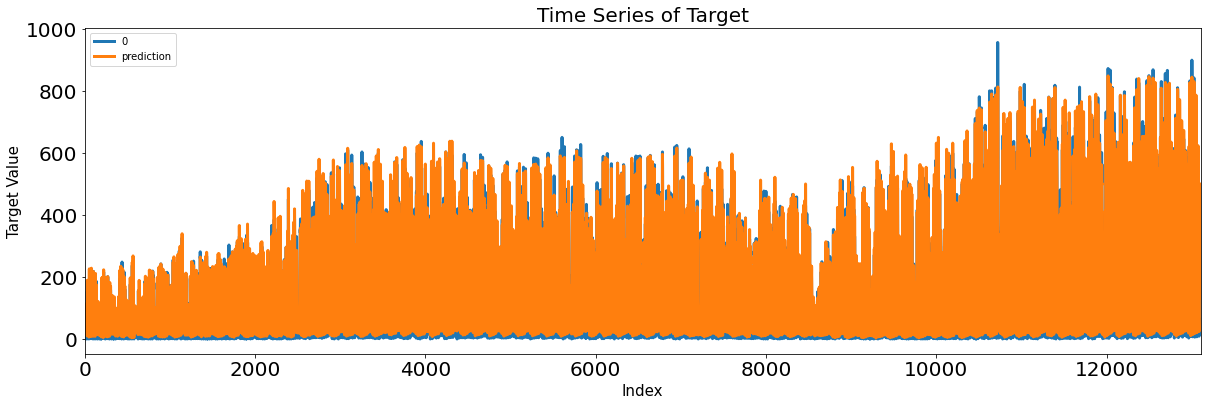

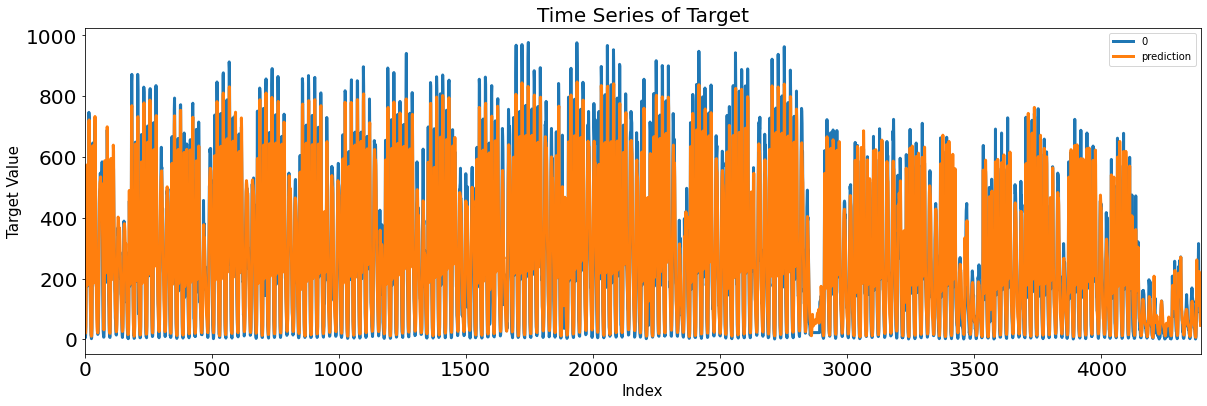

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)